# Segmenting and clustering neighborhoods in Toronto

In the previous notebooks, [scraper.ipynb](scraper.ipynb) and [geocoder.ipynb](geocoder.ipynb), we obtained Toronto's neighboring data. This includes names and coordinates of each neighborhood.

In this notebook will explore these neighborhoods with the help of the Foursquare API. We will use the **explore** function to get the most common venue categories for each neighborhood, and then use this feature to group the neighborhoods into clusters. We will use the *k*-means clustering algorithm to complete this task. Finally, we will use the Folium library to visualize the neighborhoods in Toronto and their emerging clusters.

<b>TABLE OF CONTENTS</b>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#importing">Importing libraries and loading data</a></li>
        <li><a href="#explore">Exploring neighborhoods</a>
            <ul>
                <li><a href='#kensington'>Kensington Market</a></li>
                <li><a href='#venues'>Venues</a></li>
            </ul>
        </li>
        <li><a href="#analyse">Analysing each neighborhood</a></li>
        <li><a href="#modeling">Clustering neighborhoods</a></li>
        <li><a href="#examine">Examining clusters</a></li>
    </ol>
</div>

## 1. Importing libraries and loading data <a id='importing'></a>

We start by importing the libraries used for our analysis.

In [1]:
import folium
import json
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import seaborn as sns
sns.set(style="whitegrid")

from IPython.display import Image, IFrame
from IPython.core.display import HTML 
from sklearn.cluster import KMeans

We then load the data previously obtained.

In [2]:
df = pd.read_csv('data/toronto_neighborhoods.csv')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


As transformation of the dataset was done at an earlier stage, we can proceed with our exploration.

## 2. Exploring neighborhoods in Toronto <a id='explore'></a>

In [3]:
HTML('<p>The dataset contains a total of {n_rows} Toronto postal codes '
     'within {boroughs} boroughs.</p>'.format(
         n_rows=len(df),
         boroughs=len(df['Borough'].unique())))

We can use the latitude and longitude to visualize the postal codes on a map.

In [4]:
toronto_ll = [43.7043, -79.2832]
map_toronto = folium.Map(location=toronto_ll, zoom_start=10)

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto.save('maps/postalcodes.html')

In [5]:
IFrame('maps/postalcodes.html', width=600, height=300)

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

### Kensington Market <a id='kensington'></a>

Let' s have a grasp of how our analysis will be performed by focusing on a single neighborhood: Kensington Market.

According to Google serach "Kensington Market is a walkable bohemian neighbourhood that draws artists and tourists to its indie shops, vintage boutiques and arts spaces. The Market is also home to a wide array of specialty grocers, bakeries and cheese shops. Hipsters frequent trendy bars, cafes and international restaurants that range from casual to fine dining. Students and families populate Victorian houses along tree-lined streets". Sounds like a really nice area!

We can now check what type of venues it has, we will see if the description is fit for the neighborhood. First we select our info on Kensington Market from the dataset.

In [6]:
# selecting Kensington Market Record
ken_market = df.iloc[84, :]
ken_market

PostalCode                                            M5T
Borough                                  Downtown Toronto
Neighborhood    Kensington Market, Chinatown, Grange Park
Latitude                                          43.6532
Longitude                                           -79.4
Name: 84, dtype: object

Then we can use the latitude and longitude to find nearby venues. We are using the Foursquare API for this.

In [8]:
url = 'https://api.foursquare.com/v2/venues/explore'

params = dict(client_id=CLIENT_ID,
              client_secret=CLIENT_SECRET,
              v='20180323',
              ll='{lat},{lon}'.format(lat=ken_market['Latitude'], lon=ken_market['Longitude']),
              radius=500)

resp = requests.get(url=url, params=params)
results = json.loads(resp.text)

Now we can write a function to extract the categories from the json file we received as a response.

In [9]:
def get_category_type(row):
    '''Extracts the category of a venue'''
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

And then retrieve the venues.

In [10]:
venues = results['response']['groups'][0]['items']    
ken_venues = pd.json_normalize(venues) 

display(HTML('{} venues were returned. We can see the first 5:'.format(ken_venues.shape[0])))

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
ken_venues = ken_venues.loc[:, filtered_columns]
ken_venues['venue.categories'] = ken_venues.apply(get_category_type, axis=1)
ken_venues.columns = [col.split(".")[-1] for col in ken_venues.columns]
ken_venues.head()

,name,categories,lat,lng
0,Kid Icarus,Arts & Crafts Store,43.653933,-79.401719
1,Essence of Life Organics,Organic Grocery,43.654111,-79.400431
2,Blackbird Baking Co,Bakery,43.654764,-79.400566
3,Seven Lives - Tacos y Mariscos,Mexican Restaurant,43.654418,-79.400545
4,The Moonbean Cafe,Café,43.654147,-79.400182


Let's also plot the number of venues per category. We will be doing the plot with the <code>seaborn</code> library, built on <code>matplotlib</code>.

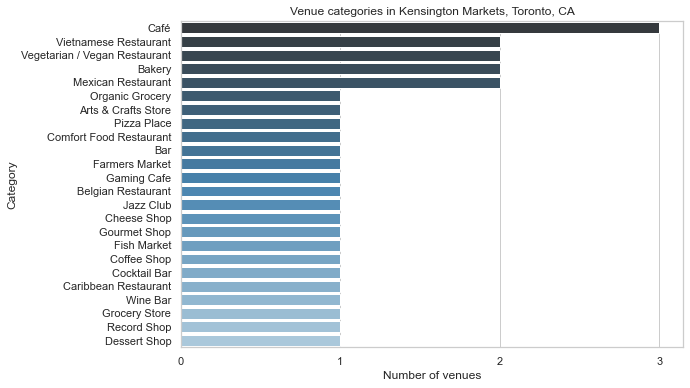

In [11]:
ken_categories_count = ken_venues['categories'].value_counts()

fig, ax = plt.subplots(figsize=(9,6))

ax = sns.barplot(ken_categories_count.values, ken_categories_count.index, palette='Blues_d', ax=ax)
ax.set_ylabel('Category')
ax.set_xlabel('Number of venues')
ax.set_title('Venue categories in Kensington Markets, Toronto, CA')
ax.set_xticks(range(ken_categories_count.values.max() + 1))
plt.show()

Judging by the type of venues in the neighborhood, seems like the description was quite accurate.

We can now start analysing all of the neighborhoods in Toronto and then we will be clustering them.

### Venues throughout Toronto <a id='venues'></a>

In order to get the venues for all neighborhoods in Toronto we will use a function that takes 4 parameters:
 - <b>names</b>: the name of the neighborhood
 - <b>latitudes</b>: the latitude of the neighborhood
 - <b>longitude</b>: the longitude of the neighborhood
 - <b>radius</b>: the search radius for venues

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore'
        params = dict(client_id=CLIENT_ID,
                      client_secret=CLIENT_SECRET,
                      v='20180323',
                      ll='{lat},{lng}'.format(lat=lat, lng=lng),
                      radius=radius,
                      limit=100)
        results = requests.get(url, params=params).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We then call the function to get the venues for all neighborhoods.

In [13]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                 latitudes=df['Latitude'],
                                 longitudes=df['Longitude'])
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


Let's check how many venues were returned for each neighborhood.

In [14]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
Berczy Park,55,55,55,55,55,55
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",17,17,17,17,17,17


Next we can plot the top 5 venue categories throughout Toronto.

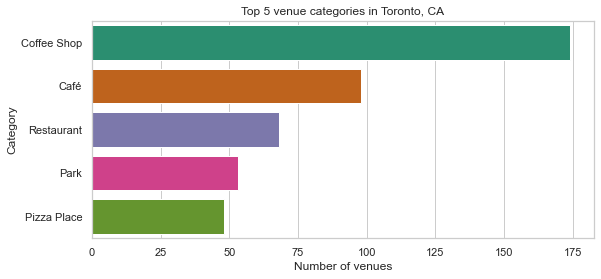

In [15]:
tor_categories_count = toronto_venues['Venue Category'].value_counts().nlargest(5)

fig, ax = plt.subplots(figsize=(9,4))

ax = sns.barplot(tor_categories_count.values, tor_categories_count.index, palette='Dark2', ax=ax)
ax.set_ylabel('Category')
ax.set_xlabel('Number of venues')
ax.set_title('Top 5 venue categories in Toronto, CA')
plt.show()

It's nice to see that parks and pizzas make it to the top 5.

In [16]:
HTML('In the dataset there are a total of {} unique venue categories.'.format(len(toronto_venues['Venue Category'].unique())))

## 3. Analysing each neighborhood <a id='analyse'></a>

Next we will be analysing each neighborhood. The initial idea is to transform the data so that it contains information about each neighborhood along with the frequancy of each venue category.

We can do this through <b>OneHotEncoding</b>.

In [17]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
col_to_order = ['Neighborhood']
new_columns = col_to_order + (toronto_onehot.columns.drop(col_to_order).tolist())
toronto_onehot = toronto_onehot[new_columns]

toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Let's examine the new dataframe size.

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [18]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [20]:
toronto_grouped.shape

(95, 269)

Great, the dataset has the 95 neighborhoods on each row and 269 venue categories on each column. 

We can plot this with a heatmap.

Normalized heatmap of venue categories in Toronto


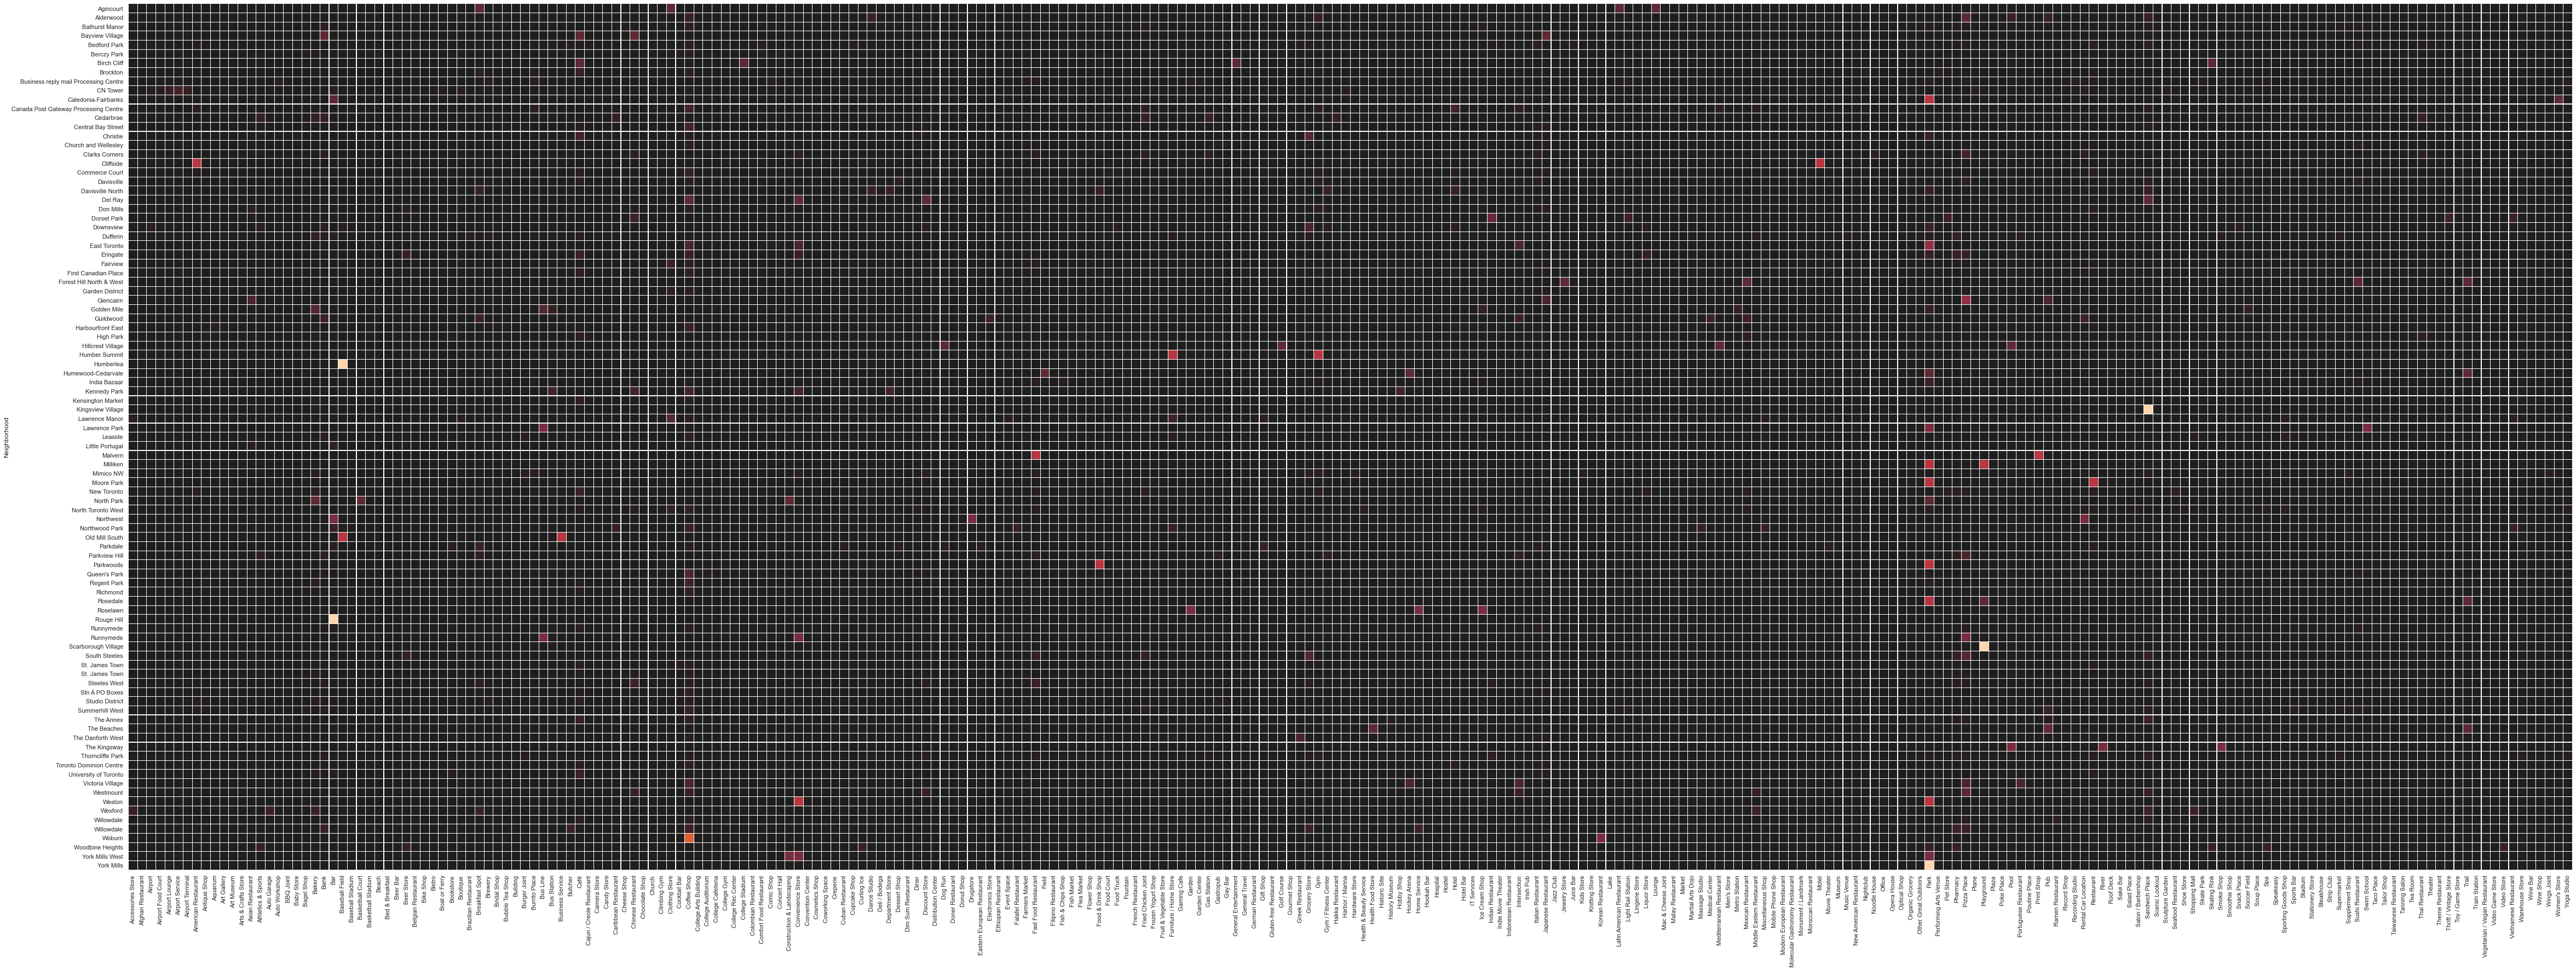

In [21]:
toronto_grouped_plot = toronto_grouped.copy()
toronto_grouped_plot['Neighborhood'] = [name[0] for name in toronto_grouped_plot['Neighborhood'].str.split(',').values]
toronto_grouped_plot = toronto_grouped_plot.set_index('Neighborhood')

fig, ax = plt.subplots(figsize=(80, 40))

sns.heatmap(toronto_grouped_plot, 
            cbar=False,
            square=True,
            linewidths=.08,
            center=0,
            ax=ax)
print('Normalized heatmap of venue categories in Toronto')
plt.show()

Now we can create a <code>DataFrame</code> with the frequency of the top 10 venues per neighborhood.

First, let's write a function to sort the venues in descending order.

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Clothing Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
1,"Alderwood, Long Branch",Pizza Place,Gym,Pool,Sandwich Place,Pub,Dance Studio,Coffee Shop,Drugstore,Donut Shop,Doner Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Park,Fried Chicken Joint,Bridal Shop,Sandwich Place,Diner,Restaurant,Deli / Bodega,Supermarket
3,Bayview Village,Café,Bank,Japanese Restaurant,Chinese Restaurant,Yoga Studio,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Greek Restaurant,Thai Restaurant,Pharmacy,Pizza Place,Cupcake Shop,Pub
5,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Bakery,Beer Bar,Seafood Restaurant,Café,Restaurant,Diner,Park
6,"Birch Cliff, Cliffside West",College Stadium,Skating Rink,General Entertainment,Café,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
7,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Performing Arts Venue,Stadium,Burrito Place,Restaurant,Climbing Gym,Pet Store,Bakery
8,"Business reply mail Processing Centre, South C...",Yoga Studio,Auto Workshop,Park,Comic Shop,Pizza Place,Recording Studio,Restaurant,Burrito Place,Brewery,Skate Park
9,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Sculpture Garden,Rental Car Location,Coffee Shop,Plane,Boat or Ferry,Bar


## 4. Clustering neighborhoods

We are ready to cluster the neighborhoods. In order to do this we will use the *k-means* algorithm from the <code>sklearn</code> module.

We will first try to find the optimal value of *k* through analysing the inertias.

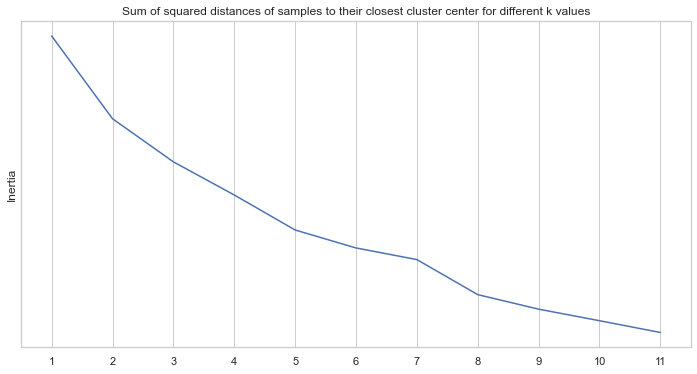

In [26]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

ks = range(1, 12)
inertias = []

for k in ks:
    k_means = KMeans(init="k-means++", n_clusters=k, n_init=12)
    k_means.fit(toronto_grouped_clustering)
    inertias.append(k_means.inertia_)
    
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ks, inertias)
ax.set_title('Sum of squared distances of samples to their closest cluster center for different k values')
ax.set_ylabel('Inertia')
ax.set_xticks([k for k in ks])
ax.set_yticks(())
plt.show()

It seems like 5 is a good value for our *k*. 

In [27]:
kclusters = 5

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [28]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df
toronto_merged = pd.merge(toronto_merged, neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() 

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,Food & Drink Shop,Park,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Hockey Arena,Coffee Shop,Portuguese Restaurant,Intersection,Pizza Place,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Department Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Park,Pub,Bakery,Breakfast Spot,Restaurant,Café,Theater,Hotel,French Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1,Clothing Store,Furniture / Home Store,Gift Shop,Boutique,Sporting Goods Shop,Miscellaneous Shop,Event Space,Accessories Store,Coffee Shop,Vietnamese Restaurant
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Sushi Restaurant,Yoga Studio,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burger Joint,Burrito Place,Café


Finally, let's visualize the resulting clusters.

In [29]:
map_clusters = folium.Map(location=toronto_ll, zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('maps/clusters.html')

In [30]:
IFrame('maps/clusters.html', width=600, height=300)

## 5. Examining clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

In [31]:
for k in range(kclusters):
    display(HTML('<h3>Cluster {k}:</h3>'.format(k=k+1)))
    display(toronto_merged.loc[toronto_merged['Cluster Labels'] == k, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]])

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,0,Hockey Arena,Coffee Shop,Portuguese Restaurant,Intersection,Pizza Place,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Department Store
8,East York,0,Pizza Place,Pharmacy,Gastropub,Gym / Fitness Center,Breakfast Spot,Bank,Intersection,Athletics & Sports,Fast Food Restaurant,General Travel
10,North York,0,Pizza Place,Asian Restaurant,Japanese Restaurant,Pub,Yoga Studio,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
51,Scarborough,0,Motel,American Restaurant,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
54,York,0,Sandwich Place,Coffee Shop,Discount Store,Convenience Store,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Distribution Center,Dog Run
60,York,0,Pizza Place,Bus Line,Convenience Store,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
67,Etobicoke,0,Pizza Place,Discount Store,Intersection,Middle Eastern Restaurant,Coffee Shop,Chinese Restaurant,Sandwich Place,Yoga Studio,Dim Sum Restaurant,Diner
69,North York,0,Pharmacy,Grocery Store,Bank,Pizza Place,Butcher,Coffee Shop,Home Service,Dog Run,Dim Sum Restaurant,Diner
74,Etobicoke,0,Sandwich Place,Yoga Studio,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant
79,Scarborough,0,Pizza Place,Rental Car Location,Fried Chicken Joint,Italian Restaurant,Fast Food Restaurant,Noodle House,Convenience Store,Thai Restaurant,Bank,Gas Station


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,1,Coffee Shop,Park,Pub,Bakery,Breakfast Spot,Restaurant,Café,Theater,Hotel,French Restaurant
3,North York,1,Clothing Store,Furniture / Home Store,Gift Shop,Boutique,Sporting Goods Shop,Miscellaneous Shop,Event Space,Accessories Store,Coffee Shop,Vietnamese Restaurant
4,Downtown Toronto,1,Coffee Shop,Sushi Restaurant,Yoga Studio,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burger Joint,Burrito Place,Café
5,Scarborough,1,Fast Food Restaurant,Print Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Deli / Bodega
6,North York,1,Gym,Beer Store,Restaurant,Japanese Restaurant,Coffee Shop,Asian Restaurant,Chinese Restaurant,Sandwich Place,Bike Shop,Sporting Goods Shop
7,North York,1,Gym,Beer Store,Restaurant,Japanese Restaurant,Coffee Shop,Asian Restaurant,Chinese Restaurant,Sandwich Place,Bike Shop,Sporting Goods Shop
9,Downtown Toronto,1,Clothing Store,Coffee Shop,Italian Restaurant,Café,Japanese Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Cosmetics Shop,Ramen Restaurant,Fast Food Restaurant
12,East York,1,Park,Video Store,Spa,Beer Store,Athletics & Sports,Curling Ice,Skating Rink,Pharmacy,Dessert Shop,Ethiopian Restaurant
13,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Cocktail Bar,American Restaurant,Gastropub,Italian Restaurant,Theater,Gym,Clothing Store
14,York,1,Trail,Park,Field,Hockey Arena,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,2,Food & Drink Shop,Park,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
19,York,2,Park,Women's Store,Bar,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
33,East York,2,Park,Intersection,Coffee Shop,Convenience Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
46,North York,2,Park,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
58,Central Toronto,2,Park,Bus Line,Swim School,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Farmers Market
61,York,2,Convenience Store,Park,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Yoga Studio
63,North York,2,Park,Construction & Landscaping,Convenience Store,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
80,Central Toronto,2,Park,Restaurant,Yoga Studio,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
82,Scarborough,2,Park,Playground,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
88,Downtown Toronto,2,Park,Playground,Trail,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
55,North York,3,Baseball Field,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore,Field
97,Etobicoke,3,Business Service,Baseball Field,Yoga Studio,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Fast Food Restaurant


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Scarborough,4,Bar,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore,Field


## Conclusion

Based on the venues that distinguish each cluster we can rename the clusters:

 1. Cluster 1: The pizza cluster
 2. Cluster 2: The coffee and gyms cluster
 3. Cluster 3: The parks cluster
 4. Cluster 4: The baseball cluster
 5. Cluster 5: The outlier
 
 ---
 
Hope you enjoyed the analysis and that, like me, you would like to visit Toronto soon. 